# Tech Challenge - Fase 1

## Análise e previsão de despesas médicas

O conjunto de dados de seguro médico abrange vários fatores que influenciam as despesas médicas, como idade, sexo, IMC, tabagismo, número de filhos e região. Este conjunto de dados serve de base para o treinamento de modelos de aprendizado de máquina capazes de prever despesas médicas para novos segurados.


# Itens abordados:

* 1 - Análise exploratória dos dados
* 2 - Regressao linear simples
* 3 - DecisionTreeRegressor
* 4 - RandomForestRegressor




# Base de dados

- A base de dados foi obtida do kaggle.com https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download :


- **2772** registros
- Não há registros vazios
- **1435** linhas duplicadas
- Após a remoção das linhas duplicas **1337** linhas


# Atributos:

- **age**: idade
- **sex**: Sexo
- **bmi**: indice de massa corporal
- **children**: número de filhos
- **smoker**: fumante
- **region**: região
- **charges**: gasto com o plano de saúde

# 1 - Análise exploratória dos dados

**Imports necessários para execução**

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

# Functions

In [3]:
# carrega a base de dados
def initialize_database():
  dados = pd.read_csv("insurance.csv")
  #dados = pd.read_csv("medical_insurance.csv") # base do kaggle
  print("base de dados inicializada...")
  return dados


# lista os registros duplicados
def list_duplicated(dados):
  duplicados = dados.duplicated()
  numero_duplicados = duplicados.sum()
  print(f"Número de registros duplicados: {numero_duplicados}")

  linhas_duplicadas = dados[duplicados]
  #print(linhas_duplicadas)


# remove os registros duplicados
def remove_duplicated(dados):
  list_duplicated(dados);
  print(dados.shape)
  print("removendo dados duplicados...")
  # Removendo duplicados (por padrão, mantém a primeira linha)
  dados = dados.drop_duplicates()
  # reindexando a base de dados
  dados = dados.reset_index(drop=True)
  print(dados.shape)
  return dados;


# codifica as colunas categóricas em valores númericos para facilitar o uso em modelos de aprendizado de máquina.
def encoded_labels(dados):
  colunas=['sex','smoker','region']
  print("encoded_labels:", colunas )

  label_encoder = LabelEncoder()
  for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])
  return dados


# cria uma nova coluna 'bmi-types' de acordo com o intervalos definidos de classificação BMI
def category_bmi(dados):
  print("categorizando a coluna bmi -> bmi-types")
  #dados.loc[:,"bmi-types"] = pd.cut(dados["bmi"],
  dados["bmi-types"] = pd.cut(dados["bmi"],
                        bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                        labels=[1, 2, 3, 4, 5, 6]).cat.codes

  dados = dados.drop(columns = [ "bmi"]).copy()
  #dados.reset_index(drop=True)
  return dados


# cria uma nova coluna 'age-types' de acordo com as faixas etárias da ANVISA
def category_age(dados):
  print("categorizando a coluna age -> age-types")
  dados["age-types"] = pd.cut(dados["age"],
                        bins=[0, 18, 23, 28, 33, 38, 43, 48, 53, 59, np.inf],
                        labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).cat.codes
  dados = dados.drop(columns = [ "age"]).copy()
  return dados


# insere dados na base de dados até n
def run_upsampling(dados):
  print("run_upsampling")
  dados = dados.sample(n=5000, replace=True, random_state=42, ignore_index=True)
  return dados


# definindo as colunas X para predição e Y (target)
def define_x_y():
  y = dados['charges']
  X = dados[['age', 'sex', 'smoker', 'region', 'children', 'bmi-types']]
  return X, y

# definindo as colunas X para predição e Y (target)
def define_x_y_age_types():
  y = dados['charges']
  X = dados[['age-types', 'sex', 'smoker', 'region', 'children', 'bmi-types']]
  return X, y


# Esta função divide um conjunto de dados em conjuntos de treino e teste, preservando a distribuição de classes na categoria
def process_split_train_test(X, y, shuffle=True, standard_scaler=False):
    print("ShuffleSplit bmi-types:", shuffle)
    print("StandardScaler:",standard_scaler)
    if shuffle:
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#      for train_index, test_index in split.split(X, X[['age-types', 'bmi-types']]):
      for train_index, test_index in split.split(X, X['bmi-types']):
          shuffe_train = dados.loc[train_index]
          shuffe_test = dados.loc[test_index]

 #     print("% base de treino -------------------")
 #     print(shuffe_train["bmi-types"].value_counts() / len(shuffe_train))

 #     print("% base de teste ---------------------")
 #     print(shuffe_test["bmi-types"].value_counts() / len(shuffe_test))

 #     print("removendo coluna bmi-types")
      for set_ in (shuffe_train, shuffe_test):
        set_.drop("bmi-types", axis=1, inplace=True)

      X_train = shuffe_train.copy()
      y_train = X_train['charges'].copy()

      X_train = X_train.drop(columns=['charges'], axis=1)

      X_test = shuffe_test.copy()
      y_test = X_test['charges'].copy()

      X_test = X_test.drop(columns=['charges'], axis=1)
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standard_scaler:
      scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test


# Esta função divide um conjunto de dados em conjuntos de treino e teste, preservando a distribuição de classes na categoria
def process_split_train_test2(X, y, shuffle=True, standard_scaler=False):
    if shuffle:
      #print("Usando o ShuffleSplit em bmi-types")
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
      for train_index, test_index in split.split(X, X["bmi-types"]):
          shuffe_train = dados.loc[train_index]
          shuffe_test = dados.loc[test_index]
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
      for train_index, test_index in split.split(X, X["age-types"]):
          shuffe_train2 = dados.loc[train_index]
          shuffe_test2 = dados.loc[test_index]

 #     print("% base de treino -------------------")
 #     print(shuffe_train["bmi-types"].value_counts() / len(shuffe_train))

 #     print("% base de teste ---------------------")
 #     print(shuffe_test["bmi-types"].value_counts() / len(shuffe_test))

 #     print("removendo coluna bmi-types")
      for set_ in (shuffe_train, shuffe_test):
        set_.drop("bmi-types", axis=1, inplace=True)

      for set_ in (shuffe_train2, shuffe_test2):
        set_.drop("age-types", axis=1, inplace=True)

      X_train = shuffe_train.copy()
      y_train = X_train['charges'].copy()

      X_train = X_train.drop(columns=['charges'], axis=1)

      X_test = shuffe_test.copy()
      y_test = X_test['charges'].copy()

      X_test = X_test.drop(columns=['charges'], axis=1)
    else:
      #print("Não usando o ShuffleSplit")
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standard_scaler:
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


# Esta função avalia o desempenho de um modelo de regressão e retorna um dicionário com métricas de desempenho.
def model_evaluate(model, X_train, y_train, X_test, y_test, y_pred):
  #print("Avaliando o desempenho do modelo: ", model.__class__.__name__)
  mse = mean_squared_error(y_test, y_pred)

  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  mape = calculate_mape(y_test, y_pred)

  rmse = np.sqrt(mse);

#  print("mse - Mean Squared Error :", mse)
#  print("mae - Mean Absolute Error:", mae)
  print(f"Avaliando o desempenho do modelo: {model.__class__.__name__} - r2-score: {r2}")

#  print()
#  print("O score nos dá uma visão da precisão média da floresta aleatória nos dados")
#  print("score train: ", model.score(X_train, y_train))
#  print("score test : ", model.score(X_test, y_test))

  score_std, score_mean = validacao_cruzada(model)

  return {'model': model.__class__.__name__,
                    'shuffle_split_bmi': shuffle_split,
                    'upsampling': upsampling,
                    'standard_scaler': standard_scaler,
                    'mae': mae.round(2),
                    'mse': mse.round(2),
                    'rmse': rmse.round(2),
                    'mape': mape.round(2),
                    'r2-score': r2.round(4),
                    'k-fold std': score_std,
                    'k-fold mean': score_mean  }



# realiza validação cruzada k-fold para avaliar o desempenho de um modelo de regressão e retorna o desvio padrão e a média dos scores de R².
def validacao_cruzada(model, k=10):
  #print("")
  #print("Validação cruzada:", k, model.__class__.__name__,)

  # Realize a validação cruzada e armazene os resultados em 'scores'
  #scores = cross_val_score(model, X, y, cv=KFold(n_splits=k, shuffle=true, random_state=42))
  scores = cross_val_score(model, X, y, cv=KFold(n_splits=k, shuffle=True, random_state=42))

  # Imprima a média e o desvio padrão das métricas
#  print("K-Fold (R^2) Scores: {0}".format(scores))
#  print("Desvio padrão do R²:", scores.std())
  #print("Média do R²:", scores.mean())
  return scores.std(), scores.mean()


def plt_real_previsto(y_test, predictions, model):
  plt.scatter(y_test, predictions)
  plt.xlabel('Encargo Real')
  plt.ylabel('Encargo Previsto')
  plt.title('Real vs Previsto - ' + model.__class__.__name__)
  ideal_values = np.linspace(min(y_test), max(y_test))
  plt.plot(ideal_values, ideal_values, color='red', label='Ideal')
  plt.legend()
  plt.show()


# cria, treina e utiliza um modelo de regressão linear para prever valores em um conjunto de dados de teste.
def linear_regression():
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


# cria, treina e utiliza um modelo de Regressão por Árvore de Decisão para prever valores em um conjunto de dados de teste.
def decision_tree_regressor():
  model = DecisionTreeRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


#  cria, treina e utiliza um modelo de Regressão Random Forest para prever valores em um conjunto de dados de teste.
def radom_forest_regressor():
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


def addRating(evaluation, ratings):
  df = pd.DataFrame([evaluation])
  ratings = pd.concat([ratings, df], ignore_index=True)
  return ratings


def model_run(engine, ratings):
  if (engine == "decision_tree_regressor"):
    model, y_pred = decision_tree_regressor()
  elif (engine == "radom_forest_regressor"):
    model, y_pred = radom_forest_regressor()
  elif (engine == "linear_regression"):
    model, y_pred = linear_regression()

  evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

  ratings = addRating(evaluate, ratings)

  return ratings



#  Inicializando a base de dados

In [4]:
# dados = pd.read_csv("insurance2.csv")
dados = pd.read_csv("medical_insurance.csv")


# Exploração dos dados

In [5]:
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
dados.shape

(2772, 7)

In [8]:
dados

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [7]:
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2772.0,39.109668,14.081459,18.0000,26.000,39.00000,51.0000,64.00000
bmi,2772.0,30.701349,6.129449,15.9600,26.220,30.44750,34.7700,53.13000
children,2772.0,1.101732,1.214806,0.0000,0.000,1.00000,2.0000,5.00000
charges,2772.0,13261.369959,12151.768945,1121.8739,4687.797,9333.01435,16577.7795,63770.42801


In [10]:
dados.groupby('sex').describe()

age                                                         bmi  \
         count       mean        std   min   25%   50%   75%   max   count   
sex                                                                          
female  1366.0  39.481698  14.093176  18.0  27.0  40.0  52.0  64.0  1366.0   
male    1406.0  38.748222  14.065654  18.0  26.0  39.0  51.0  64.0  1406.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
sex                ...                                                     
female  30.434473  ...      2.0  5.0  1366.0  12486.831977  11049.445434   
male    30.960633  ...      2.0  5.0  1406.0  14013.872721  13094.571070   

                                                                      
              min          25%        50%           75%          max  
sex                                                                   
female  1607.5101  4804.400100  9283.5620  14418.154925  63770.42801  
male    1121.8739  4523.184438  9361.3268  19160.177000  62592.87309  

[2 rows x 32 columns]

In [ ]:
dados.groupby('smoker').describe()

age                                                          bmi  \
         count       mean        std   min    25%   50%   75%   max   count   
smoker                                                                        
no      1064.0  39.385338  14.083410  18.0  26.75  40.0  52.0  64.0  1064.0   
yes      274.0  38.514599  13.923186  18.0  27.00  38.0  49.0  64.0   274.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
smoker             ...                                                     
no      30.651795  ...      2.0  5.0  1064.0   8434.268298   5993.781819   
yes     30.708449  ...      2.0  5.0   274.0  32050.231832  11541.547176   

                                                                          
               min           25%          50%           75%          max  
smoker                                                                    
no       1121.8739   3986.438700   7345.40530  11362.887050  36910.60803  
yes     12829.4551  20826.244213  34456.34845  41019.207275  63770.42801  

[2 rows x 32 columns]

In [ ]:
dados.groupby('region').describe()

age                                                         bmi  \
           count       mean        std   min    25%   50%   75%   max  count   
region                                                                         
northeast  324.0  39.268519  14.069007  18.0  27.00  39.5  51.0  64.0  324.0   
northwest  325.0  39.196923  14.051646  19.0  26.00  39.0  51.0  64.0  325.0   
southeast  364.0  38.939560  14.164585  18.0  26.75  39.0  51.0  64.0  364.0   
southwest  325.0  39.455385  13.959886  19.0  27.00  39.0  51.0  64.0  325.0   

                      ... children      charges                              \
                mean  ...      75%  max   count          mean           std   
region                ...                                                     
northeast  29.173503  ...      2.0  5.0   324.0  13406.384516  11255.803066   
northwest  29.199785  ...      2.0  5.0   325.0  12417.575374  11072.276928   
southeast  33.355989  ...      2.0  5.0   364.0  14735.411438  13971.098589   
southwest  30.596615  ...      2.0  5.0   325.0  12346.937377  11557.179101   

                                                                          
                 min          25%           50%         75%          max  
region                                                                    
northeast  1694.7964  5194.322288  10057.652025  16687.3641  58571.07448  
northwest  1621.3402  4719.736550   8965.795750  14711.7438  60021.39897  
southeast  1121.8739  4440.886200   9294.131950  19526.2869  63770.42801  
southwest  1241.5650  4751.070000   8798.593000  13462.5200  52590.82939  

[4 rows x 32 columns]

In [ ]:
dados.groupby('children').describe()

age                                                         bmi  \
          count       mean        std   min    25%   50%   75%   max  count   
children                                                                      
0         574.0  38.444251  16.436228  18.0  22.00  36.0  55.0  64.0  574.0   
1         324.0  39.453704  12.067445  18.0  30.00  40.0  49.0  64.0  324.0   
2         240.0  39.445833  11.588715  18.0  30.00  40.0  48.0  64.0  240.0   
3         157.0  41.566879  12.206174  18.0  31.00  41.0  52.0  64.0  157.0   
4          25.0  39.000000  12.138094  18.0  29.00  39.0  48.0  61.0   25.0   
5          18.0  35.611111  10.123583  19.0  28.75  39.0  42.5  52.0   18.0   

                     ...                  charges                              \
               mean  ...       75%    max   count          mean           std   
children             ...                                                        
0         30.550296  ...  34.74625  53.13   574.0  12365.975602  12023.293942   
1         30.623148  ...  34.23750  52.58   324.0  12731.171832  11823.631451   
2         30.978104  ...  35.35750  48.07   240.0  15073.563734  12891.368347   
3         30.684331  ...  34.32000  46.53   157.0  15355.318367  12330.869484   
4         31.391200  ...  33.66000  41.47    25.0  13850.656311   9139.223321   
5         29.605000  ...  33.05500  46.75    18.0   8786.035247   3808.435525   

                                                                          
                min          25%          50%           75%          max  
children                                                                  
0         1121.8739  2734.421150   9856.95190  14440.123825  63770.42801  
1         1711.0268  4791.643175   8483.87015  15632.052050  58571.07448  
2         2304.0022  6284.939438   9264.97915  20379.276748  49577.66240  
3         3443.0640  6652.528800  10600.54830  19199.944000  60021.39897  
4         4504.6624  7512.267000  11033.66170  17128.426080  40182.24600  
5         4687.7970  5874.973900   8589.56505  10019.943975  19023.26000  

[6 rows x 24 columns]

<Axes: xlabel='age', ylabel='Count'>

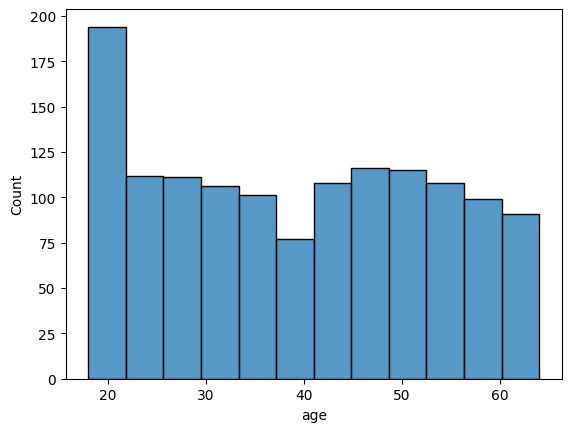

In [ ]:
sb.histplot(data=dados, x="age")

<Axes: xlabel='children', ylabel='Count'>

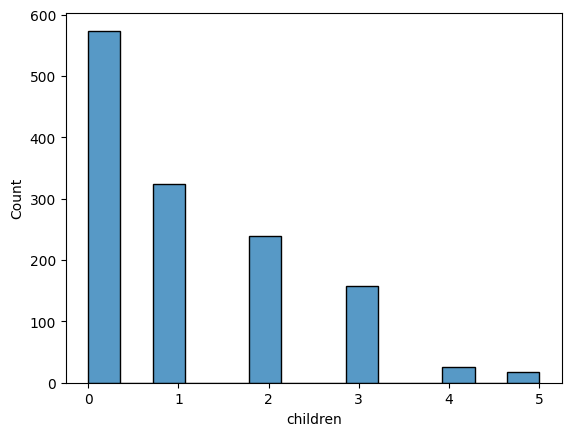

In [ ]:
sb.histplot(data=dados, x="children")

<Axes: xlabel='bmi', ylabel='Count'>

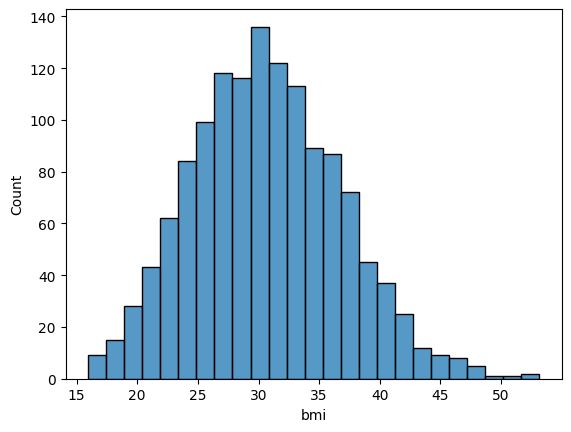

In [ ]:
sb.histplot(data=dados, x="bmi")

<Axes: ylabel='charges'>

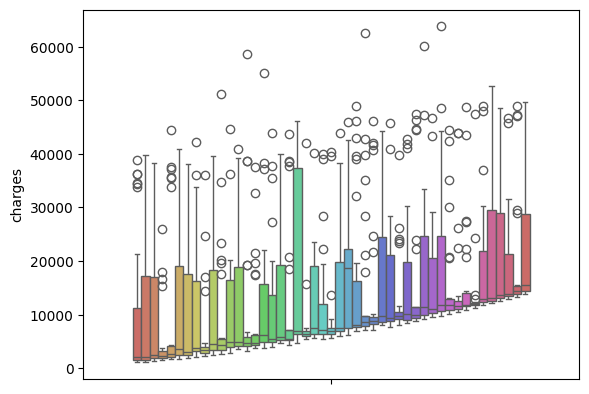

In [ ]:
sb.boxplot(hue='age', y='charges', data=dados, palette='hls', legend=False)

**Obs:** Pode ser observado nesse gráfico, a relação da idade e dos gastos, que com o avanço da idade os gastos vão aumentando....

<Axes: xlabel='smoker', ylabel='charges'>

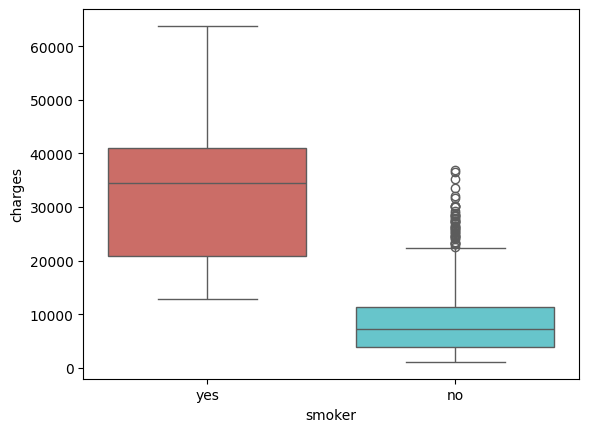

In [ ]:
sb.boxplot(x='smoker', y='charges', hue='smoker', data=dados, palette='hls', legend=False)

**Obs:** Nesse gráfico pode ser observado que o fumante tem um gasto maior, em relação ao não fumante.

<Axes: xlabel='sex', ylabel='charges'>

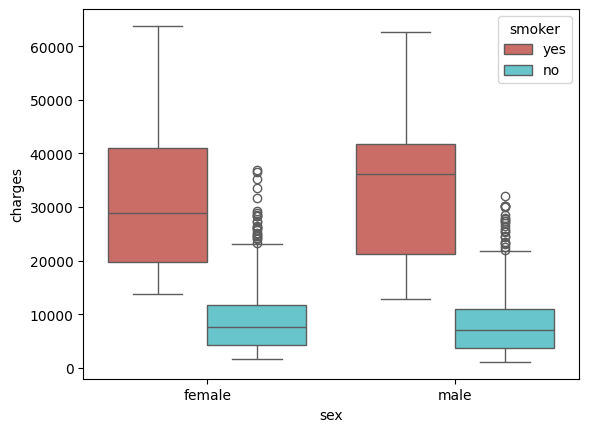

In [ ]:

sb.boxplot(x='sex', y='charges', hue='smoker', data=dados, palette='hls', legend=True)

<Axes: xlabel='charges'>

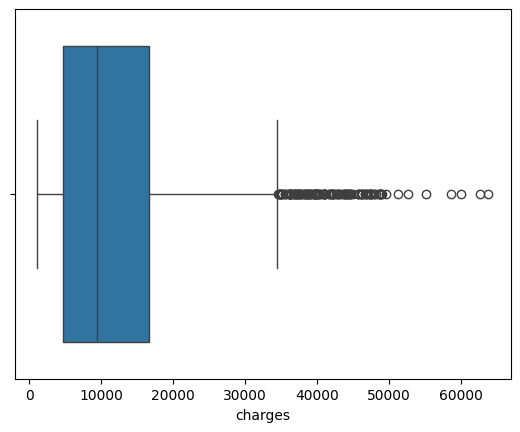

In [ ]:
sb.boxplot(x=dados["charges"])

<Axes: xlabel='bmi'>

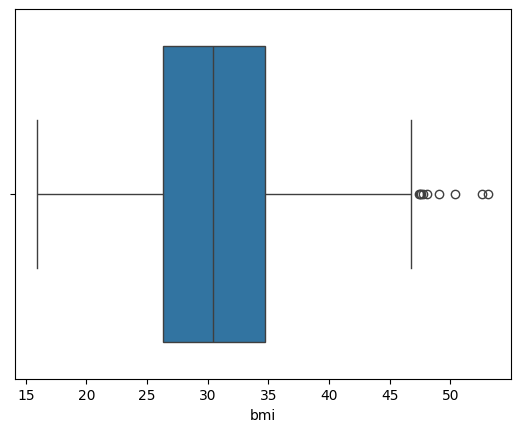

In [ ]:
sb.boxplot(x=dados["bmi"])

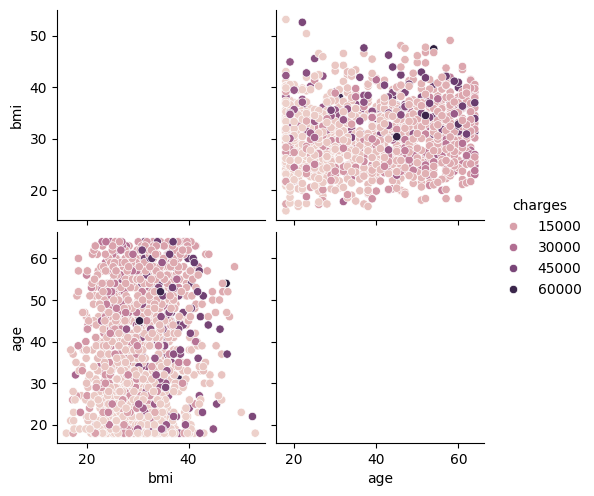

In [ ]:
sb.pairplot(dados,vars=['bmi','age'],hue="charges")

**Obs:** Nesses gráficos, pode ser observar que quanto maior o bmi (indice de massa corportal) maior o gasto com o plano de saúde, o mesmo com  avanço da idade.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 20.0% of the points cannot be plac

[Text(13.000000000000002, 0.5, '')]

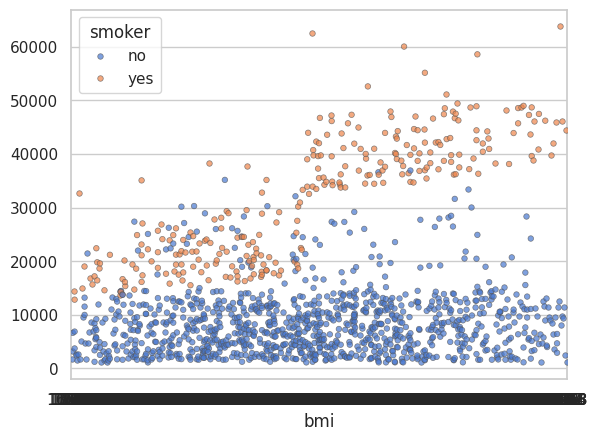

In [ ]:
sb.set_theme(style="whitegrid", palette="muted")
ax = sb.swarmplot(data=dados, x="bmi", y="charges", hue="smoker",   size=4, linewidth=0.5,  alpha=0.7)
ax.set(ylabel="")

**Obs:** Aqui neste gráfico (smoker, bmi e charges), pode perceber que fumantes tem mais gastos com o plano de saude e quanto mais alto IMC o gasto vai aumentando


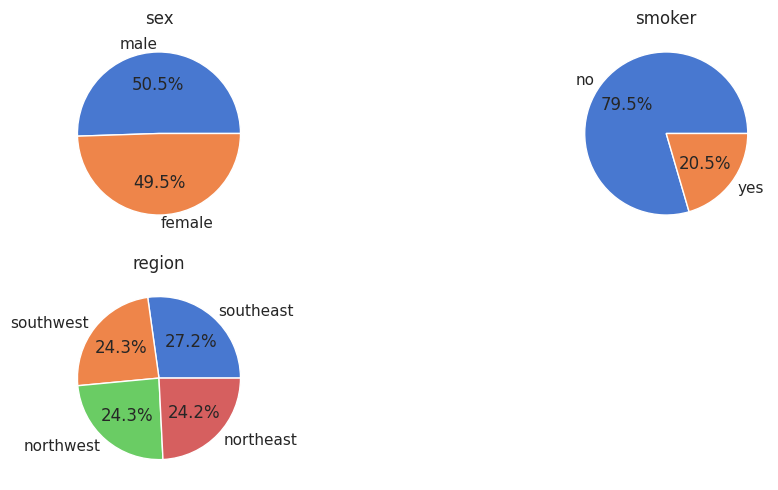

In [ ]:
plt.figure(figsize=(12,9))
for i,col in enumerate(['sex','smoker','region']):
    plt.subplot(3,2,i+1)
    x=dados[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'],labels=x[col],autopct="%0.1f%%",colors=sns.color_palette('muted'))

# Registros duplicados


* Listando os registros duplicados da base de dados




In [13]:
list_duplicated(dados)

Número de registros duplicados: 0
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


- removendo os registros duplicados

In [14]:
print(dados.shape)

dados = remove_duplicated(dados)
#dados = dados.reset_index(drop=True)

print(dados.shape)

(1337, 7)
(1337, 7)


# Remoção de valores de gastos (charges) discrepantes



In [ ]:
from scipy import stats
dados=dados[np.abs(stats.zscore(dados['charges'])) <3]
dados = dados.reset_index(drop=True)

remoção de valores discrepantes com base nas pontuações **z** em um conjunto de dados​. Quando aplicamos a regra dos **3 desvios padrão**, estamos considerando que mais de **99%** dos dados estão dentro deste intervalo em uma distribuição normal.
Assim, os valores que estão além de 3 desvios padrão da média são considerados incomuns ou **outliers**.

# 1.1 - LabelEncoder

Vamos utilizar **label enconder** para tratar variáveis categóricas: **sex, smoker e region**

In [ ]:
dados = encoded_labels(dados)

dados.head()

encoded_labels: ['sex', 'smoker', 'region']


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


# 1.2 - Categorizando BMI

**`O índice de massa corporal ( IMC )`** é um valor derivado da massa ( peso ) e altura de uma pessoa. O IMC é definido como a massa corporal dividida pelo quadrado da altura corporal e é expresso em unidades de kg/m 2




IMC, categorias básicas Categoria	IMC (kg/m 2 )
- Abaixo do peso (magreza severa):	< 16,0
- Abaixo do peso (magreza moderada):	16,0 – 16,9
- Abaixo do peso (magreza leve):	17,0 – 18,4
- Intervalo normal:	18,5 – 24,9
- Excesso de peso (pré-obeso):	25,0 – 29,9
- Obeso (Classe I):	30,0 – 34,9
- Obeso (Classe II):	35,0 – 39,9
- Obeso (Classe III):	≥ 40,0

In [ ]:
dados = category_bmi(dados)
dados['bmi-types']

categorizando a coluna bmi -> bmi-types


KeyError: 'bmi'

In [ ]:
print(dados)

      age  sex  children  smoker  region      charges  bmi-types
0      55    1         0       0       3  10214.63600          2
1      37    0         2       1       3  46113.51100          5
2      58    1         0       0       0  11931.12525          2
3      39    0         5       0       2   8582.30230          1
4      18    0         4       0       0   4561.18850          3
...   ...  ...       ...     ...     ...          ...        ...
4995   31    1         5       0       0   6799.45800          2
4996   59    0         0       0       2  12244.53100          4
4997   45    1         1       0       3   7441.05300          3
4998   19    0         0       0       1   2134.90150          4
4999   20    0         0       0       3   1880.48700          3

[5000 rows x 7 columns]


# 1.4 - Upsampling

**Upsampling** é uma técnica de manipulação de dados usada para resolver o desequilíbrio de classes em conjuntos de dados, mas é importante considerar suas limitações, como **Overfitting**

In [ ]:
dados = run_upsampling(dados)

upsampling = True
dados.shape


(5000, 7)

# 1.5 - StandardScaler

**Obs:** Não há melhoras no modelo, usando StandardScaler

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_predito_random_forest_scaled = rf.predict(X_test_scaled)

model_evaluate(rf, X_train_scaled, y_train, X_test_scaled, y_test, y_predito_random_forest_scaled)

Avaliando o desempenho do modelo:  RandomForestRegressor
r2  - R-squared          : 0.9133108562375221

Validação cruzada: 10 RandomForestRegressor
Média do R²: 0.9790705388390386


{'model': 'RandomForestRegressor',
 'shuffle': True,
 'upsampling': True,
 'mae': 1407.45,
 'mse': 12499630.29,
 'rmse': 3535.48,
 'r2': 0.9133,
 'mape': 12.72,
 'k-fold std': 0.0066202143890745175,
 'k-fold mean': 0.9790705388390386}

# 1.5 - Exploração de dados após ajustes

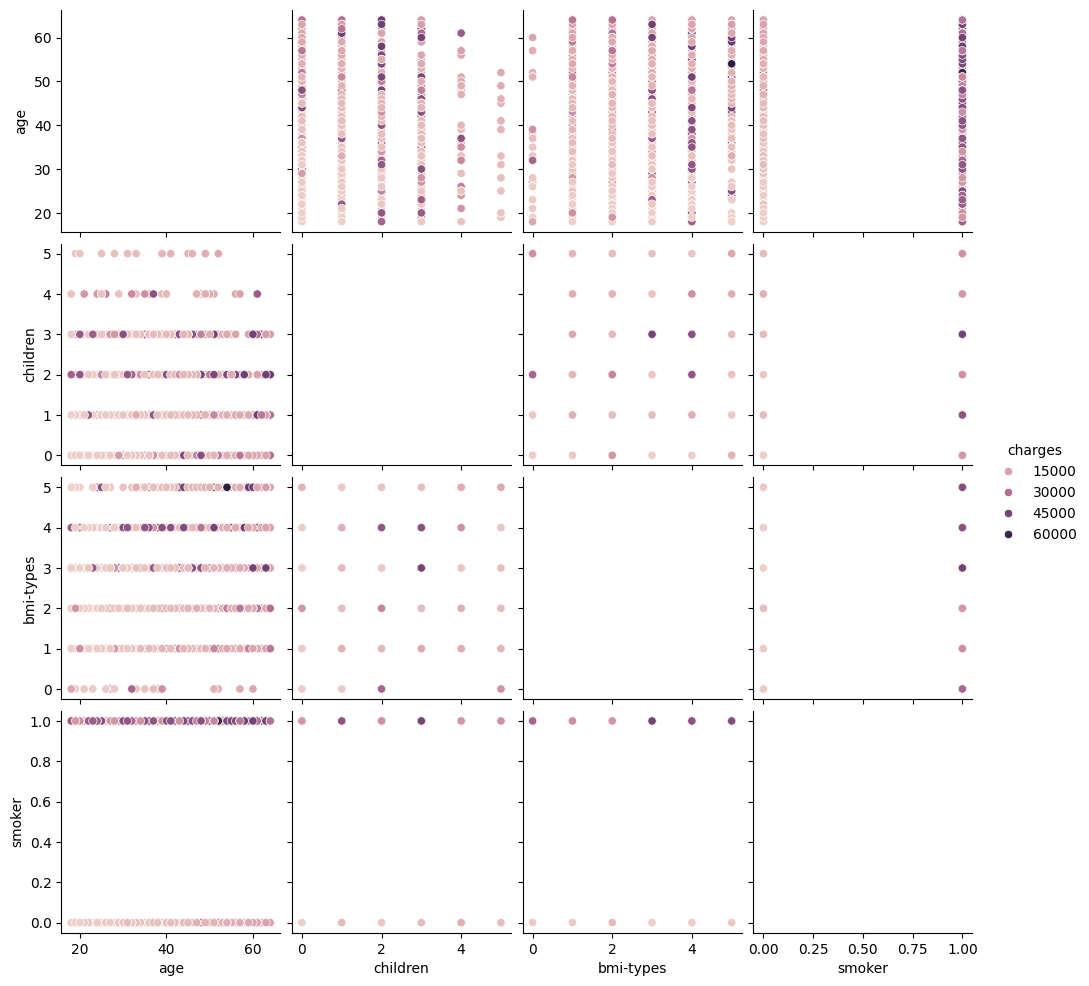

In [ ]:
sb.pairplot(dados,vars=['age','children','bmi-types','smoker'],hue="charges")


# 1.6 - Correlações

<Axes: >

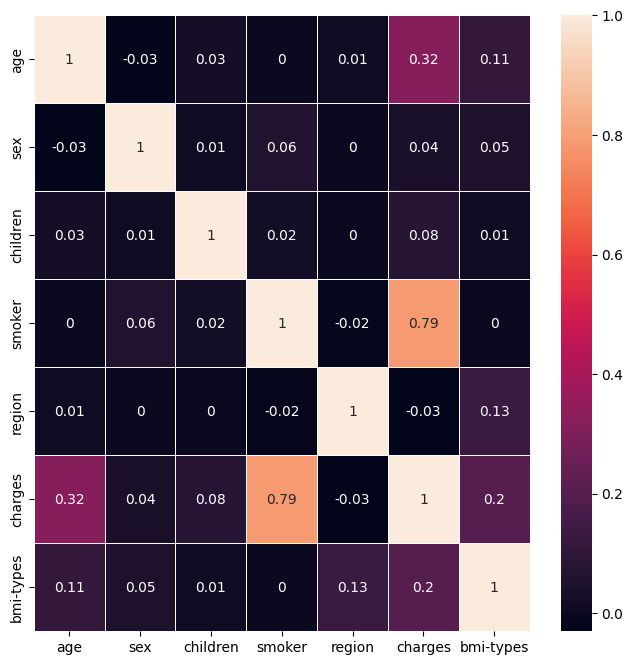

In [ ]:
correlation_matrix = dados.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

**obs:** pode ser percebido que a correlação dos gastos com a pessoa fumante é alta de 0,79 e com bmi de 0,20 e de idade 0,32

In [ ]:
correlation_matrix = dados.corr()
max_corr = correlation_matrix.stack().sort_values(ascending=False).drop_duplicates()
max_corr = max_corr[max_corr < 1].head(10)

print("Maiores correlações:")
print(max_corr)

Maiores correlações:
smoker     charges      0.788153
age        charges      0.321103
bmi-types  charges      0.196639
           region       0.133129
           age          0.114130
children   charges      0.082119
smoker     sex          0.058125
sex        bmi-types    0.054603
           charges      0.041237
age        children     0.033065
dtype: float64


# 3 - Modelo baseado Regressão Linear

**Run model linear regression**

In [10]:
X, y = define_x_y()

shuffle_split = True

X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split)

model, y_pred = linear_regression()

evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

ratings = addRating(evaluate, ratings)
ratings.head(20)

Usando o ShuffleSplit em bmi-types
Avaliando o desempenho do modelo:  LinearRegression
r2  - R-squared          : 0.7085452145169967

Validação cruzada: 10 LinearRegression
Média do R²: 0.7513379642775001


,model,shuffle,upsampling,mae,mse,rmse,r2,mape,k-fold std,k-fold mean
0,LinearRegression,False,True,4016.83,32931305.83,5738.58,0.7715,40.62,0.026387,0.751338
1,DecisionTreeRegressor,False,True,257.79,3161894.45,1778.17,0.9781,3.96,0.006019,0.978481
2,RandomForestRegressor,False,True,482.66,2956371.59,1719.41,0.9795,6.20,0.006620,0.979071
3,LinearRegression,True,True,4226.97,42024605.47,6482.64,0.7085,30.86,0.026387,0.751338
4,DecisionTreeRegressor,True,True,1115.59,13663376.20,3696.40,0.9052,11.21,0.006019,0.978481
5,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
6,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
7,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
8,DecisionTreeRegressor,False,True,257.79,3161894.45,1778.17,0.9781,3.96,0.006019,0.978481
9,LinearRegression,True,True,4226.97,42024605.47,6482.64,0.7085,30.86,0.026387,0.751338


# Visualizando previsões

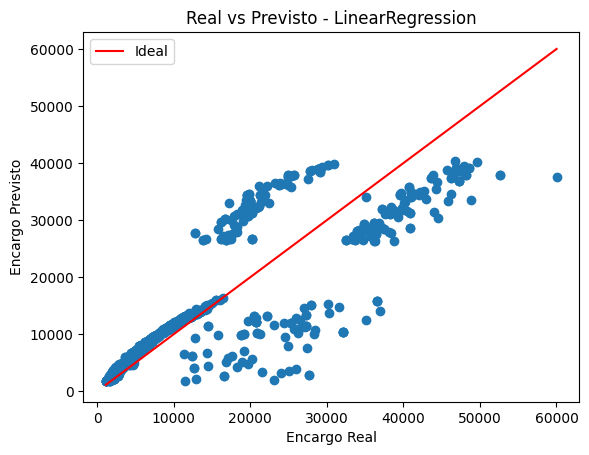

In [11]:
plt_real_previsto(y_test, y_pred, model)

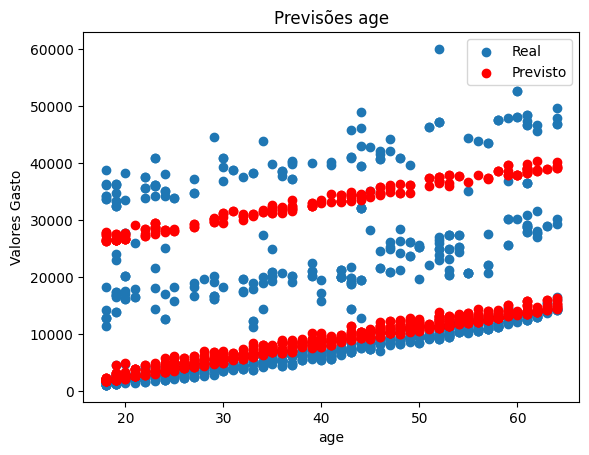

In [15]:

feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões age')
plt.legend()
plt.show()



# 3 - Modelo baseado em árvore (DecisionTreeRegressor) - - - - - - - - - - - -



**Run model decision_tree_regressor**

In [9]:
X, y = define_x_y()

shuffle_split = False

X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split)

model, y_pred = decision_tree_regressor()

evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

ratings = addRating(evaluate, ratings)
ratings.head(20)

Não usando o ShuffleSplit
Avaliando o desempenho do modelo:  DecisionTreeRegressor
r2  - R-squared          : 0.9780612358297401

Validação cruzada: 10 DecisionTreeRegressor
Média do R²: 0.9784811318404747


,model,shuffle,upsampling,mae,mse,rmse,r2,mape,k-fold std,k-fold mean
0,LinearRegression,False,True,4016.83,32931305.83,5738.58,0.7715,40.62,0.026387,0.751338
1,DecisionTreeRegressor,False,True,257.79,3161894.45,1778.17,0.9781,3.96,0.006019,0.978481
2,RandomForestRegressor,False,True,482.66,2956371.59,1719.41,0.9795,6.20,0.006620,0.979071
3,LinearRegression,True,True,4226.97,42024605.47,6482.64,0.7085,30.86,0.026387,0.751338
4,DecisionTreeRegressor,True,True,1115.59,13663376.20,3696.40,0.9052,11.21,0.006019,0.978481
5,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
6,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
7,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
8,DecisionTreeRegressor,False,True,257.79,3161894.45,1778.17,0.9781,3.96,0.006019,0.978481


**Visualizando as previsões**

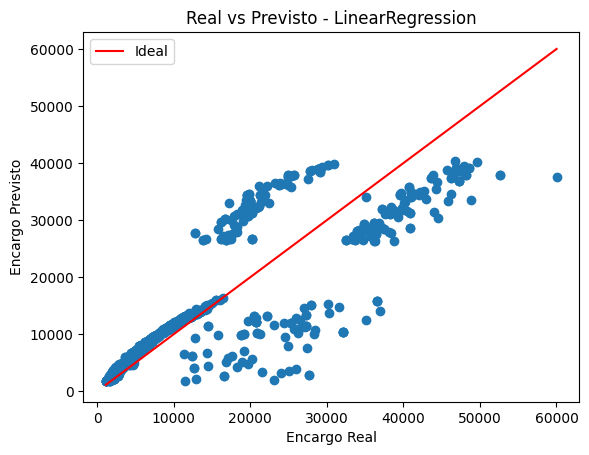

In [16]:
plt_real_previsto(y_test, y_pred, model)

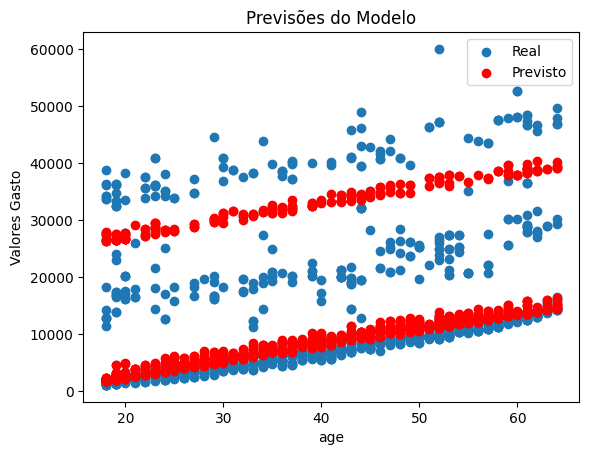

In [17]:
feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 4 - Modelo baseado em árvore (RandomForestRegressor) - - - - - - - - - - - - - -

**Run model random_tree_regressor**

In [8]:
X, y = define_x_y()

shuffle_split = True

X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split)

model, y_pred = radom_forest_regressor()

evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

ratings = addRating(evaluate, ratings)
ratings.head(20)

Usando o ShuffleSplit em bmi-types
Avaliando o desempenho do modelo:  RandomForestRegressor
r2  - R-squared          : 0.9135951281470991

Validação cruzada: 10 RandomForestRegressor
Média do R²: 0.9790705388390386


,model,shuffle,upsampling,mae,mse,rmse,r2,mape,k-fold std,k-fold mean
0,LinearRegression,False,True,4016.83,32931305.83,5738.58,0.7715,40.62,0.026387,0.751338
1,DecisionTreeRegressor,False,True,257.79,3161894.45,1778.17,0.9781,3.96,0.006019,0.978481
2,RandomForestRegressor,False,True,482.66,2956371.59,1719.41,0.9795,6.20,0.006620,0.979071
3,LinearRegression,True,True,4226.97,42024605.47,6482.64,0.7085,30.86,0.026387,0.751338
4,DecisionTreeRegressor,True,True,1115.59,13663376.20,3696.40,0.9052,11.21,0.006019,0.978481
5,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
6,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071
7,RandomForestRegressor,True,True,1404.22,12458641.38,3529.68,0.9136,12.70,0.006620,0.979071


**Vizualizando as previsões**

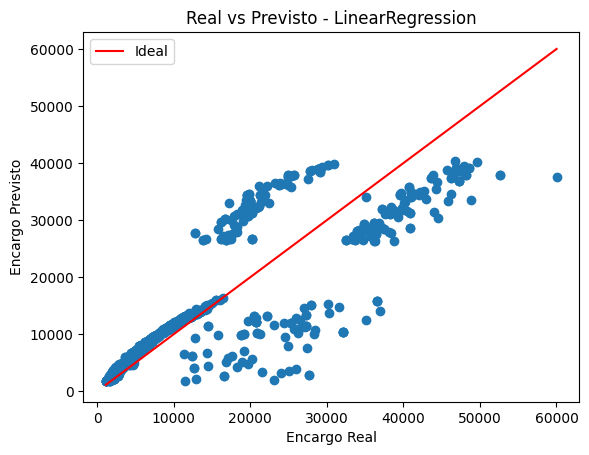

In [18]:
plt_real_previsto(y_test, y_pred, model)

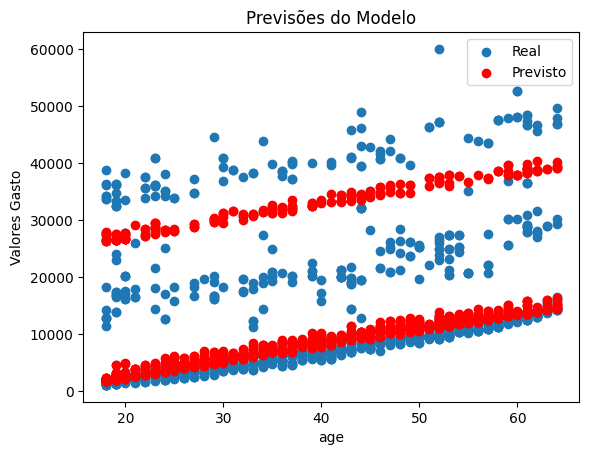

In [19]:
feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 5 - Executando todos os modelos

In [4]:
dados = pd.read_csv("medical_insurance.csv")

upsampling = False

dados = remove_duplicated(dados)

dados = encoded_labels(dados)
dados = category_bmi(dados)
# dados = category_age(dados)

ratings = pd.DataFrame();

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types


In [7]:
dados = run_upsampling(dados)
upsampling = True

run_upsampling


In [9]:
#ratings = pd.DataFrame();

X, y = define_x_y()

standard_scaler = True

shuffle_split = False
X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split, standard_scaler)

ratings = model_run("linear_regression", ratings)
ratings = model_run("decision_tree_regressor", ratings)
ratings = model_run("radom_forest_regressor", ratings)


shuffle_split = True
X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split, standard_scaler)

ratings = model_run("linear_regression", ratings)
ratings = model_run("decision_tree_regressor", ratings)
ratings = model_run("radom_forest_regressor", ratings)



print("\nResultado: Ordenado pelo melhor r2")
ratings.sort_values(by='r2-score', ascending=False)

ShuffleSplit bmi-types: False
StandardScaler: True
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.7715065562435632
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.9780523165496123
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9793130683663959
ShuffleSplit bmi-types: True
StandardScaler: True
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.7085452145169968
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.9050667994641087
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9133108562375221

Resultado: Ordenado pelo melhor r2


,model,shuffle_split_bmi,upsampling,standard_scaler,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
14,RandomForestRegressor,False,True,False,482.66,2956371.59,1719.41,6.20,0.9795,0.006620,0.979071
20,RandomForestRegressor,False,True,True,481.43,2981475.80,1726.70,6.13,0.9793,0.006620,0.979071
13,DecisionTreeRegressor,False,True,False,257.79,3161894.45,1778.17,3.96,0.9781,0.006019,0.978481
19,DecisionTreeRegressor,False,True,True,258.18,3163179.93,1778.53,3.96,0.9781,0.006019,0.978481
17,RandomForestRegressor,True,True,False,1404.22,12458641.38,3529.68,12.70,0.9136,0.006620,0.979071
23,RandomForestRegressor,True,True,True,1407.45,12499630.29,3535.48,12.72,0.9133,0.006620,0.979071
16,DecisionTreeRegressor,True,True,False,1115.59,13663376.20,3696.40,11.21,0.9052,0.006019,0.978481
22,DecisionTreeRegressor,True,True,True,1116.52,13688333.48,3699.77,11.21,0.9051,0.006019,0.978481
2,RandomForestRegressor,False,False,False,2729.80,23512302.73,4848.95,33.21,0.8720,0.029680,0.821714
8,RandomForestRegressor,False,False,True,2721.20,23556574.27,4853.51,33.14,0.8718,0.029680,0.821714


In [25]:
print("Resultado: Ordenado pelo melhor r2")
ratings.sort_values(by='r2-score', ascending=False)

Resultado: Ordenado pelo melhor r2


,model,shuffle_split_bmi,upsampling,standard_scaler,mae,mse,rmse,r2-score,mape,k-fold std,k-fold mean
2,RandomForestRegressor,False,False,True,2721.20,23556574.27,4853.51,0.8718,33.14,0.029680,0.821714
14,RandomForestRegressor,False,False,True,2721.20,23556574.27,4853.51,0.8718,33.14,0.029680,0.821714
8,RandomForestRegressor,False,False,True,2721.20,23556574.27,4853.51,0.8718,33.14,0.029680,0.821714
0,LinearRegression,False,False,True,4219.58,35696181.76,5974.63,0.8057,43.20,0.042037,0.743021
12,LinearRegression,False,False,True,4219.58,35696181.76,5974.63,0.8057,43.20,0.042037,0.743021
6,LinearRegression,False,False,True,4219.58,35696181.76,5974.63,0.8057,43.20,0.042037,0.743021
13,DecisionTreeRegressor,False,False,True,3156.32,42375738.72,6509.67,0.7694,38.07,0.048005,0.692147
7,DecisionTreeRegressor,False,False,True,3156.32,42375738.72,6509.67,0.7694,38.07,0.048005,0.692147
1,DecisionTreeRegressor,False,False,True,3156.32,42375738.72,6509.67,0.7694,38.07,0.048005,0.692147
15,LinearRegression,True,False,True,4383.17,48738372.28,6981.29,0.7112,32.07,0.042037,0.743021


**Desempenho do modelo de regressão:**

**- Mean Absolute Error (mae):**

mede a média das diferenças absolutas entre as previsões do modelo e os valores reais. Em termos simples, o MAE nos diz quão distantes, em média, as previsões estão dos valores reais. Quanto menor o valor do MAE, mais precisas são as previsões do modelo. É uma medida direta da qualidade das previsões, sem levar em conta a direção dos erros.

**- Mean Squared Error (mse):**

Em vez de calcular a média das diferenças absolutas entre previsões e valores reais, o MSE calcula a média dos quadrados dessas diferenças. Isso significa que o MSE penaliza erros grandes de forma mais significativa do que erros menores. Assim como o MAE, quanto menor o valor do MSE, melhor o desempenho do modelo. No entanto, como os erros são elevados ao quadrado, o MSE tende a ser mais sensível a valores extremos do que o MAE.

**- Erro Quadrático Médio da Raiz (rmse):**

 é uma versão do MSE que leva em conta a raiz quadrada dos erros quadráticos médios. Em essência, o RMSE é uma medida da dispersão dos erros entre as previsões e os valores reais. Como o MSE, o RMSE também penaliza erros grandes, mas devido à raiz quadrada, sua unidade é a mesma dos dados originais, o que facilita a interpretação. Assim como o MSE, quanto menor o valor do RMSE, melhor o desempenho do modelo de regressão.

**- R² Score (r2):**

é uma métrica que nos ajuda a entender o quanto as variações nas variáveis independentes explicam as variações na variável que estamos tentando prever (variável dependente) em um modelo de regressão. Quanto mais próximo de 1, melhor o modelo está em explicar a variabilidade dos dados. No entanto, é importante observar que o R² Score não indica a qualidade absoluta do modelo, mas sim a adequação do modelo em relação aos dados utilizados.

**- Mean Absolute Percentage Error (mape):**

 é uma métrica usada para avaliar a precisão de previsões em relação aos valores reais, expressando o erro médio como uma porcentagem do valor real. Ele calcula a média das diferenças percentuais absolutas entre as previsões e os valores reais.

In [ ]:
dados.head()

,age,sex,children,smoker,region,charges,bmi-types
0,55,1,0,0,3,10214.63600,2
1,37,0,2,1,3,46113.51100,5
2,58,1,0,0,0,11931.12525,2
3,39,0,5,0,2,8582.30230,1
4,18,0,4,0,0,4561.18850,3
